Source: https://www.learnopencv.com/keras-tutorial-fine-tuning-using-pre-trained-models/

# Setting up

In [1]:
import os
import sys
import shutil

import numpy as np

import cv2

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf

# progress bar
from tqdm import tqdm_notebook

C:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Checking local devices available

In [2]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [3]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 16320488385615194017, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 1468914073
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 12620604859564273198
 physical_device_desc: "device: 0, name: GeForce GTX 850M, pci bus id: 0000:01:00.0, compute capability: 5.0"]

# Loading pre-trained model

In [4]:
image_size = (299, 299, 3)

In [5]:
#Load the Xception model
from keras.applications import Xception

Using TensorFlow backend.


In [6]:
xception_conv = Xception(weights='imagenet', include_top=False, input_shape=image_size)

# Freeze the required layers

In [7]:
n_layer_free = 1

# Freeze the layers except the last 4 layers
for layer in xception_conv.layers[:-n_layer_free]:
    layer.trainable = False

# Create a new model

In [8]:
from keras import models
from keras import layers
from keras import optimizers

In [9]:
# Create the model
model = models.Sequential()

In [10]:
# Add the vgg convolutional base model
model.add(xception_conv)

In [11]:
# Add new layers
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(2, activation='softmax'))

In [12]:
 # Show a summary of the model. Check the number of trainable parameters
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 10, 10, 2048)      20861480  
_________________________________________________________________
flatten_1 (Flatten)          (None, 204800)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               52429056  
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 514       
Total params: 73,291,050
Trainable params: 52,429,570
Non-trainable params: 20,861,480
_________________________________________________________________


# Setup the data generators

## Train/test split

In [13]:
GITHUB_PATH = ".."
DL_PATH = os.path.join(GITHUB_PATH, "deep-learning")
SCRAPING_PATH = os.path.join(DL_PATH, "scraping")
GG_PATH = os.path.join(SCRAPING_PATH, "google_images")
IMAGES_PATH = os.path.join(GG_PATH, "download")

DATASET_PATH = os.path.join(DL_PATH, "datasets")

In [ ]:
classes = [dir_ for dir_ in os.listdir(IMAGES_PATH) if dir_ != ".ipynb_checkpoints"]
n_classes = len(classes)

In [ ]:
print(classes)
print(n_classes)

In [ ]:
def train_test_split(test_ratio=0.2, data_input_path=IMAGES_PATH, data_output_path = DATASET_PATH):
    
    # Creating the train and test folders if they dont exist yer
    train_path ="train"
    test_path = "test"
    paths = [train_path, test_path]
    for path in paths:
        data_path = os.path.join(data_output_path, path)
        if not os.path.exists(data_path):
            print("[MKDIR] {} folder created.".format(path))
            os.makedirs(data_path)
    
    for dir_ in os.listdir(data_input_path):
        if dir_ != ".ipynb_checkpoints":
            print("[{}] starting...".format(dir_))
            
            for path in paths:
                class_path = os.path.join(data_output_path, path, dir_)
                if not os.path.exists(class_path):
                    os.makedirs(class_path)
            
            dir_path = os.path.join(data_input_path, dir_)
            class_img = os.listdir(dir_path).copy()
            np.random.shuffle(class_img)
            train_size = int(len(class_img) * (1 - test_ratio))
            class_train = class_img[:train_size]
            class_test = class_img[train_size:]
            
            dir_path = os.path.join(data_input_path, dir_)
            
            # copy train files
            train_path_ = os.path.join(data_output_path, train_path)
            train_path_dir = os.path.join(train_path_, dir_)
            print("[{}] train copy starting...".format(dir_))
            for img in tqdm_notebook(class_train):
                img_path_src = os.path.join(dir_path, img)
                img_path_dst = os.path.join(train_path_dir, img)
                shutil.copyfile(img_path_src, img_path_dst)
            print("[{}] train copy ended.".format(dir_))
            
            # copy test files
            test_path_ = os.path.join(data_output_path, test_path)
            test_path_dir = os.path.join(test_path_, dir_)
            print("[{}] test copy starting...".format(dir_))
            for img in tqdm_notebook(class_test):
                img_path_src = os.path.join(dir_path, img)
                img_path_dst = os.path.join(test_path_dir, img)
                shutil.copyfile(img_path_src, img_path_dst)
            print("[{}] train copy ended.".format(dir_))
        
    print("All train and test copy files finished.")          
    

In [ ]:
train_test_split()

## Generators

In [14]:
train_dir = os.path.join(DATASET_PATH, "train")
test_dir = os.path.join(DATASET_PATH, "test")

In [15]:
from keras.preprocessing.image import ImageDataGenerator

In [16]:
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
 

In [17]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [18]:
# Change the batchsize according to your system RAM
train_batchsize = 2
test_batchsize = 2

In [19]:
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(image_size[0], image_size[1]),
        batch_size=train_batchsize,
        color_mode="rgb",
        class_mode='categorical')

Found 407 images belonging to 2 classes.


In [20]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(image_size[0], image_size[1]),
        batch_size=test_batchsize,
        class_mode='categorical',
        color_mode="rgb",
        shuffle=False)

Found 103 images belonging to 2 classes.


# Train the model

In [21]:
# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

In [22]:
# Train the model
history = model.fit_generator(
      train_generator,
      steps_per_epoch=train_generator.samples//train_generator.batch_size ,
      epochs=30,
      validation_data=test_generator,
      validation_steps=test_generator.samples//test_generator.batch_size,
      verbose=1)

Epoch 1/30
203/203 [==============================] - ETA: 17:38 - loss: 0.5360 - acc: 1.00 - ETA: 9:19 - loss: 2.7862 - acc: 0.7500 - ETA: 6:33 - loss: 1.8575 - acc: 0.833 - ETA: 5:09 - loss: 1.3931 - acc: 0.875 - ETA: 4:18 - loss: 2.7263 - acc: 0.800 - ETA: 3:45 - loss: 2.2737 - acc: 0.833 - ETA: 3:21 - loss: 2.1542 - acc: 0.785 - ETA: 3:02 - loss: 1.8964 - acc: 0.812 - ETA: 2:48 - loss: 3.0771 - acc: 0.722 - ETA: 2:37 - loss: 3.5753 - acc: 0.700 - ETA: 2:28 - loss: 3.9829 - acc: 0.681 - ETA: 2:20 - loss: 4.3226 - acc: 0.666 - ETA: 2:13 - loss: 3.9901 - acc: 0.692 - ETA: 2:07 - loss: 3.7051 - acc: 0.714 - ETA: 2:02 - loss: 3.9931 - acc: 0.700 - ETA: 1:58 - loss: 3.7435 - acc: 0.718 - ETA: 1:54 - loss: 4.3281 - acc: 0.676 - ETA: 1:50 - loss: 4.4807 - acc: 0.666 - ETA: 1:47 - loss: 4.2450 - acc: 0.684 - ETA: 1:44 - loss: 4.4175 - acc: 0.650 - ETA: 1:41 - loss: 4.5607 - acc: 0.642 - ETA: 1:39 - loss: 4.6705 - acc: 0.636 - ETA: 1:36 - loss: 4.4674 - acc: 0.652 - ETA: 1:34 - loss: 4.2813 

203/203 [==============================] - ETA: 1:03 - loss: 4.2256 - acc: 0.500 - ETA: 1:03 - loss: 3.4580 - acc: 0.500 - ETA: 1:04 - loss: 2.3862 - acc: 0.666 - ETA: 1:04 - loss: 3.5643 - acc: 0.625 - ETA: 1:03 - loss: 2.8514 - acc: 0.700 - ETA: 1:03 - loss: 2.5192 - acc: 0.666 - ETA: 1:03 - loss: 2.5985 - acc: 0.642 - ETA: 1:03 - loss: 2.9313 - acc: 0.562 - ETA: 1:02 - loss: 3.0398 - acc: 0.500 - ETA: 1:02 - loss: 3.3864 - acc: 0.450 - ETA: 1:02 - loss: 3.7796 - acc: 0.409 - ETA: 1:01 - loss: 3.6594 - acc: 0.416 - ETA: 1:01 - loss: 3.3840 - acc: 0.461 - ETA: 1:01 - loss: 3.3808 - acc: 0.464 - ETA: 1:00 - loss: 3.3118 - acc: 0.466 - ETA: 1:00 - loss: 3.1050 - acc: 0.500 - ETA: 1:00 - loss: 2.9398 - acc: 0.529 - ETA: 59s - loss: 2.8690 - acc: 0.500 - ETA: 59s - loss: 3.0469 - acc: 0.50 - ETA: 59s - loss: 2.8991 - acc: 0.52 - ETA: 58s - loss: 2.8185 - acc: 0.52 - ETA: 58s - loss: 2.7820 - acc: 0.52 - ETA: 58s - loss: 2.9286 - acc: 0.50 - ETA: 57s - loss: 2.9061 - acc: 0.50 - ETA: 57s -

203/203 [==============================] - ETA: 1:01 - loss: 0.7329 - acc: 0.500 - ETA: 1:04 - loss: 1.1032 - acc: 0.250 - ETA: 1:04 - loss: 0.9346 - acc: 0.333 - ETA: 1:04 - loss: 0.8582 - acc: 0.375 - ETA: 1:03 - loss: 0.8574 - acc: 0.400 - ETA: 1:03 - loss: 1.2410 - acc: 0.333 - ETA: 1:03 - loss: 1.2886 - acc: 0.285 - ETA: 1:03 - loss: 1.2073 - acc: 0.312 - ETA: 1:02 - loss: 1.2494 - acc: 0.277 - ETA: 1:02 - loss: 1.1988 - acc: 0.300 - ETA: 1:01 - loss: 1.0948 - acc: 0.363 - ETA: 1:01 - loss: 1.0306 - acc: 0.416 - ETA: 1:01 - loss: 0.9852 - acc: 0.423 - ETA: 1:01 - loss: 0.9983 - acc: 0.428 - ETA: 1:00 - loss: 0.9991 - acc: 0.433 - ETA: 1:00 - loss: 1.0446 - acc: 0.437 - ETA: 1:00 - loss: 1.0821 - acc: 0.411 - ETA: 59s - loss: 1.0616 - acc: 0.388 - ETA: 59s - loss: 1.1940 - acc: 0.36 - ETA: 59s - loss: 1.1638 - acc: 0.37 - ETA: 58s - loss: 1.1320 - acc: 0.38 - ETA: 58s - loss: 1.0861 - acc: 0.40 - ETA: 58s - loss: 1.1265 - acc: 0.39 - ETA: 57s - loss: 1.0959 - acc: 0.41 - ETA: 57s -

203/203 [==============================] - ETA: 1:03 - loss: 1.4275 - acc: 0.0000e+0 - ETA: 1:03 - loss: 1.3031 - acc: 0.0000e+0 - ETA: 1:04 - loss: 0.9760 - acc: 0.3333    - ETA: 1:03 - loss: 0.7664 - acc: 0.500 - ETA: 1:03 - loss: 0.6381 - acc: 0.600 - ETA: 1:03 - loss: 0.5955 - acc: 0.666 - ETA: 1:03 - loss: 0.5465 - acc: 0.714 - ETA: 1:03 - loss: 0.5201 - acc: 0.750 - ETA: 1:02 - loss: 0.4863 - acc: 0.777 - ETA: 1:02 - loss: 0.5178 - acc: 0.750 - ETA: 1:01 - loss: 0.5717 - acc: 0.727 - ETA: 1:01 - loss: 0.9059 - acc: 0.708 - ETA: 1:01 - loss: 0.8489 - acc: 0.730 - ETA: 1:01 - loss: 0.8038 - acc: 0.750 - ETA: 1:00 - loss: 0.7611 - acc: 0.766 - ETA: 1:00 - loss: 0.8323 - acc: 0.718 - ETA: 1:00 - loss: 0.7996 - acc: 0.735 - ETA: 59s - loss: 0.7765 - acc: 0.722 - ETA: 59s - loss: 0.7404 - acc: 0.73 - ETA: 59s - loss: 0.8026 - acc: 0.72 - ETA: 58s - loss: 0.7966 - acc: 0.71 - ETA: 58s - loss: 0.7678 - acc: 0.72 - ETA: 58s - loss: 0.7360 - acc: 0.73 - ETA: 57s - loss: 0.7878 - acc: 0.72 

203/203 [==============================] - ETA: 1:03 - loss: 1.7526 - acc: 0.0000e+0 - ETA: 1:03 - loss: 1.3979 - acc: 0.0000e+0 - ETA: 1:03 - loss: 1.0725 - acc: 0.3333    - ETA: 1:03 - loss: 1.1967 - acc: 0.250 - ETA: 1:03 - loss: 1.1156 - acc: 0.300 - ETA: 1:03 - loss: 0.9921 - acc: 0.416 - ETA: 1:02 - loss: 1.0442 - acc: 0.428 - ETA: 1:02 - loss: 1.0272 - acc: 0.437 - ETA: 1:02 - loss: 0.9738 - acc: 0.444 - ETA: 1:02 - loss: 0.9679 - acc: 0.450 - ETA: 1:01 - loss: 0.9388 - acc: 0.454 - ETA: 1:01 - loss: 0.8906 - acc: 0.500 - ETA: 1:01 - loss: 0.8767 - acc: 0.500 - ETA: 1:00 - loss: 0.8210 - acc: 0.535 - ETA: 1:00 - loss: 0.7958 - acc: 0.566 - ETA: 1:00 - loss: 0.7719 - acc: 0.593 - ETA: 59s - loss: 0.7852 - acc: 0.588 - ETA: 59s - loss: 0.7658 - acc: 0.61 - ETA: 59s - loss: 0.7814 - acc: 0.60 - ETA: 58s - loss: 0.7736 - acc: 0.62 - ETA: 58s - loss: 0.7542 - acc: 0.64 - ETA: 58s - loss: 0.7436 - acc: 0.63 - ETA: 58s - loss: 0.7543 - acc: 0.60 - ETA: 57s - loss: 0.7472 - acc: 0.60 - 

203/203 [==============================] - ETA: 1:04 - loss: 0.8930 - acc: 0.0000e+0 - ETA: 1:05 - loss: 0.7395 - acc: 0.5000    - ETA: 1:04 - loss: 0.6454 - acc: 0.500 - ETA: 1:04 - loss: 0.6643 - acc: 0.500 - ETA: 1:04 - loss: 0.6081 - acc: 0.600 - ETA: 1:03 - loss: 0.6130 - acc: 0.583 - ETA: 1:03 - loss: 0.5984 - acc: 0.571 - ETA: 1:02 - loss: 0.6269 - acc: 0.562 - ETA: 1:02 - loss: 0.6425 - acc: 0.555 - ETA: 1:02 - loss: 0.6630 - acc: 0.550 - ETA: 1:02 - loss: 0.6529 - acc: 0.590 - ETA: 1:01 - loss: 0.6448 - acc: 0.625 - ETA: 1:01 - loss: 0.6178 - acc: 0.653 - ETA: 1:01 - loss: 0.6135 - acc: 0.678 - ETA: 1:00 - loss: 0.9054 - acc: 0.633 - ETA: 1:00 - loss: 0.8839 - acc: 0.625 - ETA: 1:00 - loss: 0.9134 - acc: 0.588 - ETA: 59s - loss: 0.9149 - acc: 0.555 - ETA: 59s - loss: 0.9115 - acc: 0.52 - ETA: 59s - loss: 0.9131 - acc: 0.50 - ETA: 58s - loss: 0.9004 - acc: 0.50 - ETA: 58s - loss: 0.8903 - acc: 0.50 - ETA: 58s - loss: 0.9027 - acc: 0.50 - ETA: 57s - loss: 0.8862 - acc: 0.52 - ET

203/203 [==============================] - ETA: 1:02 - loss: 1.4263 - acc: 0.500 - ETA: 1:04 - loss: 1.0580 - acc: 0.500 - ETA: 1:03 - loss: 0.8795 - acc: 0.500 - ETA: 1:04 - loss: 0.8704 - acc: 0.500 - ETA: 1:03 - loss: 0.8695 - acc: 0.500 - ETA: 1:03 - loss: 1.1157 - acc: 0.416 - ETA: 1:03 - loss: 1.0921 - acc: 0.357 - ETA: 1:02 - loss: 1.0123 - acc: 0.437 - ETA: 1:02 - loss: 1.1833 - acc: 0.444 - ETA: 1:02 - loss: 1.1256 - acc: 0.450 - ETA: 1:02 - loss: 1.0781 - acc: 0.500 - ETA: 1:01 - loss: 1.0151 - acc: 0.541 - ETA: 1:01 - loss: 1.2312 - acc: 0.500 - ETA: 1:01 - loss: 1.1770 - acc: 0.535 - ETA: 1:00 - loss: 1.2873 - acc: 0.533 - ETA: 1:00 - loss: 1.2227 - acc: 0.562 - ETA: 1:00 - loss: 1.2592 - acc: 0.529 - ETA: 59s - loss: 1.2196 - acc: 0.527 - ETA: 59s - loss: 1.1701 - acc: 0.55 - ETA: 59s - loss: 1.1565 - acc: 0.55 - ETA: 58s - loss: 1.1205 - acc: 0.57 - ETA: 58s - loss: 1.2083 - acc: 0.56 - ETA: 58s - loss: 1.2277 - acc: 0.56 - ETA: 57s - loss: 1.1852 - acc: 0.58 - ETA: 57s -

203/203 [==============================] - ETA: 1:02 - loss: 0.6382 - acc: 0.500 - ETA: 1:04 - loss: 0.8904 - acc: 0.500 - ETA: 1:03 - loss: 0.6730 - acc: 0.666 - ETA: 1:04 - loss: 0.5760 - acc: 0.750 - ETA: 1:03 - loss: 0.7842 - acc: 0.600 - ETA: 1:03 - loss: 0.6743 - acc: 0.666 - ETA: 1:03 - loss: 0.7363 - acc: 0.642 - ETA: 1:02 - loss: 0.7452 - acc: 0.625 - ETA: 1:02 - loss: 0.7433 - acc: 0.611 - ETA: 1:02 - loss: 0.7279 - acc: 0.600 - ETA: 1:01 - loss: 0.8794 - acc: 0.545 - ETA: 1:01 - loss: 0.8403 - acc: 0.583 - ETA: 1:01 - loss: 0.8679 - acc: 0.538 - ETA: 1:01 - loss: 0.8343 - acc: 0.571 - ETA: 1:00 - loss: 0.8265 - acc: 0.566 - ETA: 1:00 - loss: 0.7889 - acc: 0.593 - ETA: 1:00 - loss: 0.7909 - acc: 0.588 - ETA: 59s - loss: 0.7909 - acc: 0.583 - ETA: 59s - loss: 0.7774 - acc: 0.60 - ETA: 59s - loss: 0.7720 - acc: 0.60 - ETA: 58s - loss: 0.7637 - acc: 0.59 - ETA: 58s - loss: 0.7586 - acc: 0.59 - ETA: 58s - loss: 0.7682 - acc: 0.56 - ETA: 57s - loss: 0.7478 - acc: 0.58 - ETA: 57s -

203/203 [==============================] - ETA: 1:02 - loss: 0.6850 - acc: 0.500 - ETA: 1:03 - loss: 1.3079 - acc: 0.250 - ETA: 1:03 - loss: 1.3438 - acc: 0.333 - ETA: 1:03 - loss: 1.0443 - acc: 0.500 - ETA: 1:03 - loss: 0.9752 - acc: 0.500 - ETA: 1:03 - loss: 1.0675 - acc: 0.500 - ETA: 1:03 - loss: 1.1303 - acc: 0.428 - ETA: 1:02 - loss: 1.1272 - acc: 0.437 - ETA: 1:02 - loss: 1.0570 - acc: 0.500 - ETA: 1:02 - loss: 1.0454 - acc: 0.450 - ETA: 1:01 - loss: 0.9936 - acc: 0.500 - ETA: 1:01 - loss: 0.9293 - acc: 0.541 - ETA: 1:01 - loss: 0.9802 - acc: 0.538 - ETA: 1:00 - loss: 0.9605 - acc: 0.500 - ETA: 1:00 - loss: 0.9293 - acc: 0.500 - ETA: 1:00 - loss: 0.9136 - acc: 0.500 - ETA: 59s - loss: 0.8745 - acc: 0.529 - ETA: 59s - loss: 0.8336 - acc: 0.55 - ETA: 59s - loss: 0.8340 - acc: 0.55 - ETA: 58s - loss: 0.8123 - acc: 0.57 - ETA: 58s - loss: 0.8334 - acc: 0.57 - ETA: 58s - loss: 0.8211 - acc: 0.56 - ETA: 57s - loss: 0.8267 - acc: 0.54 - ETA: 57s - loss: 0.8119 - acc: 0.56 - ETA: 57s - l

203/203 [==============================] - ETA: 1:03 - loss: 1.1103 - acc: 0.0000e+0 - ETA: 1:03 - loss: 0.7004 - acc: 0.5000    - ETA: 1:04 - loss: 0.5289 - acc: 0.666 - ETA: 1:04 - loss: 0.6279 - acc: 0.625 - ETA: 1:03 - loss: 0.6529 - acc: 0.500 - ETA: 1:03 - loss: 0.7496 - acc: 0.500 - ETA: 1:03 - loss: 0.7551 - acc: 0.500 - ETA: 1:02 - loss: 0.6806 - acc: 0.562 - ETA: 1:02 - loss: 0.6184 - acc: 0.611 - ETA: 1:02 - loss: 0.6731 - acc: 0.600 - ETA: 1:02 - loss: 0.7522 - acc: 0.590 - ETA: 1:01 - loss: 0.6997 - acc: 0.625 - ETA: 1:01 - loss: 0.7047 - acc: 0.615 - ETA: 1:01 - loss: 0.6547 - acc: 0.642 - ETA: 1:00 - loss: 0.6205 - acc: 0.666 - ETA: 1:00 - loss: 0.5974 - acc: 0.687 - ETA: 1:00 - loss: 0.6172 - acc: 0.676 - ETA: 59s - loss: 0.5881 - acc: 0.694 - ETA: 59s - loss: 0.6469 - acc: 0.68 - ETA: 59s - loss: 0.6269 - acc: 0.70 - ETA: 58s - loss: 0.6024 - acc: 0.71 - ETA: 58s - loss: 0.5916 - acc: 0.70 - ETA: 58s - loss: 0.5767 - acc: 0.71 - ETA: 57s - loss: 0.6049 - acc: 0.68 - ET

203/203 [==============================] - ETA: 1:04 - loss: 0.8000 - acc: 0.500 - ETA: 1:03 - loss: 0.4194 - acc: 0.750 - ETA: 1:04 - loss: 0.3216 - acc: 0.833 - ETA: 1:04 - loss: 0.4438 - acc: 0.750 - ETA: 1:03 - loss: 0.4834 - acc: 0.700 - ETA: 1:03 - loss: 0.4713 - acc: 0.666 - ETA: 1:02 - loss: 0.4537 - acc: 0.714 - ETA: 1:02 - loss: 0.5959 - acc: 0.687 - ETA: 1:02 - loss: 0.7815 - acc: 0.666 - ETA: 1:01 - loss: 0.7843 - acc: 0.600 - ETA: 1:01 - loss: 0.7693 - acc: 0.636 - ETA: 1:01 - loss: 0.7538 - acc: 0.666 - ETA: 1:01 - loss: 0.7630 - acc: 0.653 - ETA: 1:00 - loss: 0.7586 - acc: 0.642 - ETA: 1:00 - loss: 0.7636 - acc: 0.633 - ETA: 1:00 - loss: 0.8432 - acc: 0.593 - ETA: 59s - loss: 0.8611 - acc: 0.558 - ETA: 59s - loss: 0.8217 - acc: 0.58 - ETA: 59s - loss: 0.8041 - acc: 0.57 - ETA: 59s - loss: 0.7804 - acc: 0.60 - ETA: 58s - loss: 0.7744 - acc: 0.59 - ETA: 58s - loss: 0.7551 - acc: 0.61 - ETA: 58s - loss: 0.7630 - acc: 0.58 - ETA: 57s - loss: 0.7349 - acc: 0.60 - ETA: 57s - l

203/203 [==============================] - ETA: 1:04 - loss: 0.3569 - acc: 1.000 - ETA: 1:04 - loss: 0.5264 - acc: 0.750 - ETA: 1:04 - loss: 0.7141 - acc: 0.666 - ETA: 1:03 - loss: 0.7995 - acc: 0.625 - ETA: 1:03 - loss: 0.7481 - acc: 0.700 - ETA: 1:03 - loss: 0.7548 - acc: 0.666 - ETA: 1:02 - loss: 0.6808 - acc: 0.714 - ETA: 1:02 - loss: 0.6583 - acc: 0.687 - ETA: 1:02 - loss: 0.6680 - acc: 0.611 - ETA: 1:02 - loss: 0.6318 - acc: 0.650 - ETA: 1:01 - loss: 0.7166 - acc: 0.590 - ETA: 1:01 - loss: 0.6900 - acc: 0.583 - ETA: 1:01 - loss: 0.6625 - acc: 0.615 - ETA: 1:00 - loss: 0.6311 - acc: 0.642 - ETA: 1:00 - loss: 0.6002 - acc: 0.666 - ETA: 1:00 - loss: 0.5851 - acc: 0.687 - ETA: 59s - loss: 0.5563 - acc: 0.705 - ETA: 59s - loss: 0.6022 - acc: 0.66 - ETA: 59s - loss: 0.6820 - acc: 0.63 - ETA: 58s - loss: 0.6611 - acc: 0.65 - ETA: 58s - loss: 0.7092 - acc: 0.64 - ETA: 58s - loss: 0.6967 - acc: 0.65 - ETA: 58s - loss: 0.7194 - acc: 0.65 - ETA: 57s - loss: 0.6916 - acc: 0.66 - ETA: 57s - l

203/203 [==============================] - ETA: 1:03 - loss: 0.9230 - acc: 0.0000e+0 - ETA: 1:04 - loss: 0.9264 - acc: 0.0000e+0 - ETA: 1:04 - loss: 0.8396 - acc: 0.3333    - ETA: 1:03 - loss: 0.8281 - acc: 0.375 - ETA: 1:03 - loss: 0.6856 - acc: 0.500 - ETA: 1:03 - loss: 0.6542 - acc: 0.500 - ETA: 1:02 - loss: 0.7728 - acc: 0.500 - ETA: 1:02 - loss: 0.7293 - acc: 0.562 - ETA: 1:02 - loss: 0.6926 - acc: 0.555 - ETA: 1:02 - loss: 0.6570 - acc: 0.600 - ETA: 1:01 - loss: 0.6399 - acc: 0.636 - ETA: 1:01 - loss: 0.7637 - acc: 0.583 - ETA: 1:01 - loss: 0.7388 - acc: 0.576 - ETA: 1:00 - loss: 0.7021 - acc: 0.607 - ETA: 1:00 - loss: 0.7044 - acc: 0.600 - ETA: 1:00 - loss: 0.7089 - acc: 0.593 - ETA: 59s - loss: 1.1649 - acc: 0.558 - ETA: 59s - loss: 1.1352 - acc: 0.55 - ETA: 59s - loss: 1.1492 - acc: 0.55 - ETA: 59s - loss: 1.1031 - acc: 0.57 - ETA: 58s - loss: 1.0580 - acc: 0.59 - ETA: 58s - loss: 1.0410 - acc: 0.59 - ETA: 58s - loss: 1.0220 - acc: 0.60 - ETA: 57s - loss: 1.0321 - acc: 0.60 - 

203/203 [==============================] - ETA: 1:03 - loss: 0.5622 - acc: 0.500 - ETA: 1:04 - loss: 0.4244 - acc: 0.750 - ETA: 1:04 - loss: 0.4909 - acc: 0.833 - ETA: 1:03 - loss: 0.6049 - acc: 0.750 - ETA: 1:03 - loss: 0.5375 - acc: 0.800 - ETA: 1:03 - loss: 0.5449 - acc: 0.750 - ETA: 1:03 - loss: 0.5537 - acc: 0.785 - ETA: 1:02 - loss: 0.5766 - acc: 0.750 - ETA: 1:02 - loss: 0.6420 - acc: 0.666 - ETA: 1:01 - loss: 0.6076 - acc: 0.700 - ETA: 1:01 - loss: 0.6600 - acc: 0.636 - ETA: 1:01 - loss: 0.6398 - acc: 0.666 - ETA: 1:01 - loss: 0.6322 - acc: 0.692 - ETA: 1:00 - loss: 0.6263 - acc: 0.678 - ETA: 1:00 - loss: 0.6076 - acc: 0.700 - ETA: 1:00 - loss: 0.6187 - acc: 0.687 - ETA: 59s - loss: 0.6201 - acc: 0.676 - ETA: 59s - loss: 0.6130 - acc: 0.66 - ETA: 59s - loss: 0.6274 - acc: 0.65 - ETA: 59s - loss: 0.6105 - acc: 0.67 - ETA: 58s - loss: 0.6101 - acc: 0.66 - ETA: 58s - loss: 0.6498 - acc: 0.63 - ETA: 58s - loss: 0.6527 - acc: 0.60 - ETA: 57s - loss: 0.6422 - acc: 0.62 - ETA: 57s - l

203/203 [==============================] - ETA: 1:03 - loss: 0.7450 - acc: 0.500 - ETA: 1:04 - loss: 1.5183 - acc: 0.500 - ETA: 1:04 - loss: 1.2044 - acc: 0.500 - ETA: 1:03 - loss: 1.1697 - acc: 0.375 - ETA: 1:03 - loss: 1.0423 - acc: 0.400 - ETA: 1:03 - loss: 0.8739 - acc: 0.500 - ETA: 1:03 - loss: 0.7892 - acc: 0.571 - ETA: 1:02 - loss: 0.8042 - acc: 0.500 - ETA: 1:02 - loss: 0.7299 - acc: 0.555 - ETA: 1:02 - loss: 0.6988 - acc: 0.550 - ETA: 1:01 - loss: 0.7101 - acc: 0.545 - ETA: 1:01 - loss: 0.6536 - acc: 0.583 - ETA: 1:01 - loss: 0.6216 - acc: 0.615 - ETA: 1:00 - loss: 0.5852 - acc: 0.642 - ETA: 1:00 - loss: 0.5498 - acc: 0.666 - ETA: 1:00 - loss: 0.5863 - acc: 0.656 - ETA: 59s - loss: 0.5918 - acc: 0.647 - ETA: 59s - loss: 0.6211 - acc: 0.63 - ETA: 59s - loss: 0.6501 - acc: 0.63 - ETA: 58s - loss: 0.7564 - acc: 0.60 - ETA: 58s - loss: 0.8441 - acc: 0.59 - ETA: 58s - loss: 0.8133 - acc: 0.61 - ETA: 58s - loss: 0.7804 - acc: 0.63 - ETA: 57s - loss: 0.8001 - acc: 0.62 - ETA: 57s - l

203/203 [==============================] - ETA: 1:04 - loss: 2.7118 - acc: 0.500 - ETA: 1:04 - loss: 1.9120 - acc: 0.500 - ETA: 1:04 - loss: 1.6787 - acc: 0.500 - ETA: 1:04 - loss: 1.2665 - acc: 0.625 - ETA: 1:04 - loss: 1.1170 - acc: 0.600 - ETA: 1:03 - loss: 1.0171 - acc: 0.666 - ETA: 1:03 - loss: 0.8953 - acc: 0.714 - ETA: 1:02 - loss: 0.9192 - acc: 0.625 - ETA: 1:02 - loss: 0.8783 - acc: 0.611 - ETA: 1:02 - loss: 0.8161 - acc: 0.650 - ETA: 1:02 - loss: 0.8369 - acc: 0.636 - ETA: 1:01 - loss: 0.8812 - acc: 0.583 - ETA: 1:01 - loss: 0.8339 - acc: 0.615 - ETA: 1:00 - loss: 0.7865 - acc: 0.642 - ETA: 1:00 - loss: 0.8195 - acc: 0.600 - ETA: 1:00 - loss: 0.7781 - acc: 0.625 - ETA: 1:00 - loss: 0.7741 - acc: 0.617 - ETA: 59s - loss: 0.7909 - acc: 0.611 - ETA: 59s - loss: 0.8528 - acc: 0.57 - ETA: 59s - loss: 0.8445 - acc: 0.57 - ETA: 58s - loss: 0.8122 - acc: 0.59 - ETA: 58s - loss: 0.8023 - acc: 0.59 - ETA: 57s - loss: 0.8024 - acc: 0.56 - ETA: 57s - loss: 0.7848 - acc: 0.58 - ETA: 57s -

203/203 [==============================] - ETA: 1:03 - loss: 1.4541 - acc: 0.500 - ETA: 1:04 - loss: 1.0006 - acc: 0.750 - ETA: 1:04 - loss: 0.7486 - acc: 0.833 - ETA: 1:04 - loss: 0.5800 - acc: 0.875 - ETA: 1:03 - loss: 0.8841 - acc: 0.700 - ETA: 1:03 - loss: 0.9252 - acc: 0.666 - ETA: 1:02 - loss: 0.8788 - acc: 0.642 - ETA: 1:02 - loss: 0.9240 - acc: 0.625 - ETA: 1:02 - loss: 0.8331 - acc: 0.666 - ETA: 1:02 - loss: 0.8350 - acc: 0.650 - ETA: 1:01 - loss: 0.8391 - acc: 0.636 - ETA: 1:01 - loss: 0.7791 - acc: 0.666 - ETA: 1:01 - loss: 0.7984 - acc: 0.653 - ETA: 1:01 - loss: 0.7506 - acc: 0.678 - ETA: 1:00 - loss: 0.7617 - acc: 0.666 - ETA: 1:00 - loss: 0.8912 - acc: 0.656 - ETA: 1:00 - loss: 0.8468 - acc: 0.676 - ETA: 59s - loss: 0.8329 - acc: 0.694 - ETA: 59s - loss: 0.8009 - acc: 0.71 - ETA: 59s - loss: 0.7809 - acc: 0.70 - ETA: 58s - loss: 0.7843 - acc: 0.69 - ETA: 58s - loss: 0.7872 - acc: 0.68 - ETA: 58s - loss: 0.8014 - acc: 0.67 - ETA: 57s - loss: 0.8062 - acc: 0.64 - ETA: 57s -

203/203 [==============================] - ETA: 1:05 - loss: 0.0011 - acc: 1.000 - ETA: 1:05 - loss: 0.2545 - acc: 0.750 - ETA: 1:04 - loss: 0.3086 - acc: 0.666 - ETA: 1:04 - loss: 0.3117 - acc: 0.750 - ETA: 1:04 - loss: 0.2515 - acc: 0.800 - ETA: 1:03 - loss: 0.2822 - acc: 0.750 - ETA: 1:03 - loss: 0.4903 - acc: 0.714 - ETA: 1:03 - loss: 0.4461 - acc: 0.750 - ETA: 1:02 - loss: 0.5594 - acc: 0.722 - ETA: 1:02 - loss: 0.6710 - acc: 0.650 - ETA: 1:02 - loss: 0.6567 - acc: 0.636 - ETA: 1:01 - loss: 0.6078 - acc: 0.666 - ETA: 1:01 - loss: 0.6451 - acc: 0.615 - ETA: 1:01 - loss: 0.6288 - acc: 0.642 - ETA: 1:00 - loss: 0.6258 - acc: 0.633 - ETA: 1:00 - loss: 0.7517 - acc: 0.625 - ETA: 1:00 - loss: 0.7271 - acc: 0.647 - ETA: 59s - loss: 0.6987 - acc: 0.666 - ETA: 59s - loss: 0.6864 - acc: 0.68 - ETA: 59s - loss: 0.6705 - acc: 0.70 - ETA: 58s - loss: 0.6711 - acc: 0.69 - ETA: 58s - loss: 0.6710 - acc: 0.68 - ETA: 58s - loss: 0.6482 - acc: 0.69 - ETA: 57s - loss: 0.6227 - acc: 0.70 - ETA: 57s -

203/203 [==============================] - ETA: 1:05 - loss: 0.3032 - acc: 1.000 - ETA: 1:04 - loss: 0.9726 - acc: 0.500 - ETA: 1:04 - loss: 0.7680 - acc: 0.666 - ETA: 1:04 - loss: 1.1939 - acc: 0.625 - ETA: 1:03 - loss: 0.9792 - acc: 0.700 - ETA: 1:03 - loss: 1.3962 - acc: 0.666 - ETA: 1:03 - loss: 1.2867 - acc: 0.642 - ETA: 1:03 - loss: 1.1589 - acc: 0.687 - ETA: 1:02 - loss: 1.2057 - acc: 0.611 - ETA: 1:02 - loss: 1.0867 - acc: 0.650 - ETA: 1:02 - loss: 1.0437 - acc: 0.636 - ETA: 1:01 - loss: 1.0364 - acc: 0.583 - ETA: 1:01 - loss: 1.0369 - acc: 0.538 - ETA: 1:01 - loss: 1.1961 - acc: 0.535 - ETA: 1:00 - loss: 1.1640 - acc: 0.533 - ETA: 1:00 - loss: 1.1241 - acc: 0.562 - ETA: 1:00 - loss: 1.0897 - acc: 0.558 - ETA: 59s - loss: 1.0573 - acc: 0.555 - ETA: 59s - loss: 1.0081 - acc: 0.57 - ETA: 59s - loss: 0.9610 - acc: 0.60 - ETA: 58s - loss: 0.9437 - acc: 0.59 - ETA: 58s - loss: 0.9378 - acc: 0.59 - ETA: 58s - loss: 0.9499 - acc: 0.58 - ETA: 57s - loss: 0.9146 - acc: 0.60 - ETA: 57s -

203/203 [==============================] - ETA: 1:05 - loss: 0.5156 - acc: 1.000 - ETA: 1:04 - loss: 0.2702 - acc: 1.000 - ETA: 1:04 - loss: 0.3095 - acc: 1.000 - ETA: 1:04 - loss: 0.7210 - acc: 0.750 - ETA: 1:03 - loss: 0.5977 - acc: 0.800 - ETA: 1:03 - loss: 0.5002 - acc: 0.833 - ETA: 1:03 - loss: 0.9194 - acc: 0.714 - ETA: 1:02 - loss: 0.8413 - acc: 0.750 - ETA: 1:02 - loss: 0.8235 - acc: 0.722 - ETA: 1:02 - loss: 0.8683 - acc: 0.700 - ETA: 1:01 - loss: 0.8654 - acc: 0.636 - ETA: 1:01 - loss: 0.8106 - acc: 0.666 - ETA: 1:01 - loss: 0.9629 - acc: 0.653 - ETA: 1:01 - loss: 0.9272 - acc: 0.642 - ETA: 1:00 - loss: 0.8812 - acc: 0.666 - ETA: 1:00 - loss: 0.9094 - acc: 0.625 - ETA: 1:00 - loss: 0.9430 - acc: 0.617 - ETA: 59s - loss: 0.8997 - acc: 0.638 - ETA: 59s - loss: 0.8574 - acc: 0.65 - ETA: 59s - loss: 0.9021 - acc: 0.65 - ETA: 58s - loss: 0.8802 - acc: 0.64 - ETA: 58s - loss: 0.8676 - acc: 0.63 - ETA: 58s - loss: 0.9581 - acc: 0.60 - ETA: 57s - loss: 0.9214 - acc: 0.62 - ETA: 57s -

203/203 [==============================] - ETA: 1:04 - loss: 0.4161 - acc: 0.500 - ETA: 1:04 - loss: 0.2470 - acc: 0.750 - ETA: 1:04 - loss: 0.2144 - acc: 0.833 - ETA: 1:04 - loss: 0.6484 - acc: 0.750 - ETA: 1:03 - loss: 0.6336 - acc: 0.700 - ETA: 1:03 - loss: 0.8529 - acc: 0.583 - ETA: 1:03 - loss: 0.7720 - acc: 0.642 - ETA: 1:02 - loss: 0.7193 - acc: 0.625 - ETA: 1:02 - loss: 0.6653 - acc: 0.666 - ETA: 1:02 - loss: 0.6879 - acc: 0.650 - ETA: 1:01 - loss: 0.6442 - acc: 0.681 - ETA: 1:01 - loss: 0.6021 - acc: 0.708 - ETA: 1:01 - loss: 0.5814 - acc: 0.730 - ETA: 1:01 - loss: 0.6020 - acc: 0.714 - ETA: 1:00 - loss: 0.6205 - acc: 0.700 - ETA: 1:00 - loss: 0.6318 - acc: 0.687 - ETA: 1:00 - loss: 0.6242 - acc: 0.676 - ETA: 59s - loss: 0.6156 - acc: 0.694 - ETA: 59s - loss: 0.5851 - acc: 0.71 - ETA: 59s - loss: 0.5835 - acc: 0.70 - ETA: 58s - loss: 0.5816 - acc: 0.69 - ETA: 58s - loss: 0.5552 - acc: 0.70 - ETA: 58s - loss: 0.5348 - acc: 0.71 - ETA: 57s - loss: 0.5514 - acc: 0.70 - ETA: 57s -

203/203 [==============================] - ETA: 1:05 - loss: 1.5206 - acc: 0.0000e+0 - ETA: 1:05 - loss: 0.7604 - acc: 0.5000    - ETA: 1:04 - loss: 0.8213 - acc: 0.500 - ETA: 1:04 - loss: 0.8114 - acc: 0.500 - ETA: 1:04 - loss: 0.6657 - acc: 0.600 - ETA: 1:03 - loss: 0.6918 - acc: 0.500 - ETA: 1:03 - loss: 0.7256 - acc: 0.428 - ETA: 1:03 - loss: 0.6573 - acc: 0.500 - ETA: 1:02 - loss: 0.6026 - acc: 0.555 - ETA: 1:02 - loss: 0.5964 - acc: 0.550 - ETA: 1:02 - loss: 0.7295 - acc: 0.500 - ETA: 1:01 - loss: 0.6791 - acc: 0.541 - ETA: 1:01 - loss: 0.6698 - acc: 0.538 - ETA: 1:01 - loss: 0.7092 - acc: 0.500 - ETA: 1:00 - loss: 0.7882 - acc: 0.500 - ETA: 1:00 - loss: 0.7964 - acc: 0.500 - ETA: 1:00 - loss: 0.7536 - acc: 0.529 - ETA: 59s - loss: 0.7181 - acc: 0.555 - ETA: 59s - loss: 0.6806 - acc: 0.57 - ETA: 59s - loss: 0.6487 - acc: 0.60 - ETA: 58s - loss: 0.6573 - acc: 0.59 - ETA: 58s - loss: 0.7296 - acc: 0.59 - ETA: 58s - loss: 0.7254 - acc: 0.60 - ETA: 57s - loss: 0.7061 - acc: 0.62 - ET

203/203 [==============================] - ETA: 1:07 - loss: 1.1449 - acc: 0.500 - ETA: 1:07 - loss: 0.7959 - acc: 0.750 - ETA: 1:09 - loss: 0.6248 - acc: 0.833 - ETA: 1:09 - loss: 0.4732 - acc: 0.875 - ETA: 1:08 - loss: 0.4114 - acc: 0.900 - ETA: 1:08 - loss: 0.3619 - acc: 0.916 - ETA: 1:08 - loss: 0.3589 - acc: 0.928 - ETA: 1:07 - loss: 0.3978 - acc: 0.875 - ETA: 1:07 - loss: 0.3554 - acc: 0.888 - ETA: 1:07 - loss: 0.4911 - acc: 0.850 - ETA: 1:06 - loss: 0.4646 - acc: 0.863 - ETA: 1:06 - loss: 0.5024 - acc: 0.833 - ETA: 1:05 - loss: 0.5281 - acc: 0.807 - ETA: 1:05 - loss: 0.5277 - acc: 0.821 - ETA: 1:04 - loss: 0.5697 - acc: 0.766 - ETA: 1:04 - loss: 0.7219 - acc: 0.718 - ETA: 1:04 - loss: 0.6851 - acc: 0.735 - ETA: 1:03 - loss: 0.6776 - acc: 0.722 - ETA: 1:03 - loss: 0.6476 - acc: 0.736 - ETA: 1:03 - loss: 0.6395 - acc: 0.750 - ETA: 1:02 - loss: 0.6108 - acc: 0.761 - ETA: 1:02 - loss: 0.6001 - acc: 0.750 - ETA: 1:02 - loss: 0.5985 - acc: 0.739 - ETA: 1:02 - loss: 0.6744 - acc: 0.708

203/203 [==============================] - ETA: 1:04 - loss: 1.3030 - acc: 0.500 - ETA: 1:04 - loss: 0.9184 - acc: 0.500 - ETA: 1:04 - loss: 0.9960 - acc: 0.333 - ETA: 1:04 - loss: 0.8078 - acc: 0.500 - ETA: 1:03 - loss: 0.6896 - acc: 0.600 - ETA: 1:03 - loss: 0.7199 - acc: 0.583 - ETA: 1:03 - loss: 0.7804 - acc: 0.571 - ETA: 1:02 - loss: 0.7675 - acc: 0.562 - ETA: 1:02 - loss: 0.6988 - acc: 0.611 - ETA: 1:02 - loss: 0.6316 - acc: 0.650 - ETA: 1:02 - loss: 0.6268 - acc: 0.636 - ETA: 1:01 - loss: 0.6042 - acc: 0.625 - ETA: 1:01 - loss: 0.5688 - acc: 0.653 - ETA: 1:01 - loss: 0.5554 - acc: 0.642 - ETA: 1:00 - loss: 0.7404 - acc: 0.600 - ETA: 1:00 - loss: 0.7093 - acc: 0.625 - ETA: 1:00 - loss: 0.7217 - acc: 0.588 - ETA: 59s - loss: 0.6891 - acc: 0.611 - ETA: 59s - loss: 0.6716 - acc: 0.63 - ETA: 59s - loss: 0.6740 - acc: 0.62 - ETA: 58s - loss: 0.6705 - acc: 0.61 - ETA: 58s - loss: 0.6997 - acc: 0.59 - ETA: 58s - loss: 0.6710 - acc: 0.60 - ETA: 57s - loss: 0.6564 - acc: 0.62 - ETA: 57s -

203/203 [==============================] - ETA: 1:06 - loss: 1.3892 - acc: 0.500 - ETA: 1:04 - loss: 1.3605 - acc: 0.500 - ETA: 1:04 - loss: 0.9628 - acc: 0.666 - ETA: 1:03 - loss: 1.0132 - acc: 0.500 - ETA: 1:03 - loss: 0.8178 - acc: 0.600 - ETA: 1:03 - loss: 0.8422 - acc: 0.500 - ETA: 1:03 - loss: 0.7921 - acc: 0.500 - ETA: 1:02 - loss: 0.9148 - acc: 0.437 - ETA: 1:02 - loss: 0.9122 - acc: 0.444 - ETA: 1:02 - loss: 0.8469 - acc: 0.500 - ETA: 1:01 - loss: 1.2311 - acc: 0.454 - ETA: 1:01 - loss: 1.1700 - acc: 0.458 - ETA: 1:01 - loss: 1.0827 - acc: 0.500 - ETA: 1:00 - loss: 1.0247 - acc: 0.535 - ETA: 1:00 - loss: 0.9566 - acc: 0.566 - ETA: 1:00 - loss: 0.9269 - acc: 0.593 - ETA: 59s - loss: 0.8951 - acc: 0.588 - ETA: 59s - loss: 0.8530 - acc: 0.61 - ETA: 59s - loss: 0.8129 - acc: 0.63 - ETA: 58s - loss: 0.7729 - acc: 0.65 - ETA: 58s - loss: 0.7542 - acc: 0.64 - ETA: 58s - loss: 0.7845 - acc: 0.63 - ETA: 57s - loss: 0.7541 - acc: 0.65 - ETA: 57s - loss: 0.7239 - acc: 0.66 - ETA: 57s - l

203/203 [==============================] - ETA: 1:02 - loss: 0.4994 - acc: 1.000 - ETA: 1:03 - loss: 0.3933 - acc: 1.000 - ETA: 1:03 - loss: 0.5901 - acc: 0.833 - ETA: 1:03 - loss: 0.7356 - acc: 0.750 - ETA: 1:03 - loss: 0.5950 - acc: 0.800 - ETA: 1:03 - loss: 0.5406 - acc: 0.833 - ETA: 1:02 - loss: 0.4704 - acc: 0.857 - ETA: 1:02 - loss: 0.4173 - acc: 0.875 - ETA: 1:02 - loss: 0.3887 - acc: 0.888 - ETA: 1:01 - loss: 0.3842 - acc: 0.900 - ETA: 1:01 - loss: 0.3764 - acc: 0.909 - ETA: 1:01 - loss: 0.3898 - acc: 0.875 - ETA: 1:01 - loss: 0.4232 - acc: 0.846 - ETA: 1:00 - loss: 0.4575 - acc: 0.821 - ETA: 1:00 - loss: 0.4277 - acc: 0.833 - ETA: 1:00 - loss: 0.4049 - acc: 0.843 - ETA: 59s - loss: 0.4299 - acc: 0.823 - ETA: 59s - loss: 0.4077 - acc: 0.83 - ETA: 59s - loss: 0.3940 - acc: 0.84 - ETA: 58s - loss: 0.3880 - acc: 0.85 - ETA: 58s - loss: 0.3752 - acc: 0.85 - ETA: 58s - loss: 0.3863 - acc: 0.84 - ETA: 57s - loss: 0.3962 - acc: 0.82 - ETA: 57s - loss: 0.3840 - acc: 0.83 - ETA: 57s - l

203/203 [==============================] - ETA: 1:05 - loss: 1.2934 - acc: 0.0000e+0 - ETA: 1:05 - loss: 0.6965 - acc: 0.5000    - ETA: 1:04 - loss: 0.7279 - acc: 0.500 - ETA: 1:04 - loss: 0.6153 - acc: 0.625 - ETA: 1:03 - loss: 0.5036 - acc: 0.700 - ETA: 1:03 - loss: 0.4590 - acc: 0.750 - ETA: 1:03 - loss: 0.6048 - acc: 0.642 - ETA: 1:03 - loss: 1.2783 - acc: 0.625 - ETA: 1:02 - loss: 1.2340 - acc: 0.555 - ETA: 1:02 - loss: 1.1190 - acc: 0.600 - ETA: 1:02 - loss: 1.0316 - acc: 0.636 - ETA: 1:01 - loss: 1.0080 - acc: 0.625 - ETA: 1:01 - loss: 1.0715 - acc: 0.576 - ETA: 1:01 - loss: 0.9958 - acc: 0.607 - ETA: 1:00 - loss: 0.9719 - acc: 0.600 - ETA: 1:00 - loss: 0.9120 - acc: 0.625 - ETA: 59s - loss: 0.9130 - acc: 0.617 - ETA: 59s - loss: 0.8631 - acc: 0.63 - ETA: 59s - loss: 0.8220 - acc: 0.65 - ETA: 59s - loss: 0.8197 - acc: 0.65 - ETA: 58s - loss: 0.8169 - acc: 0.64 - ETA: 58s - loss: 0.7973 - acc: 0.65 - ETA: 58s - loss: 0.7645 - acc: 0.67 - ETA: 57s - loss: 0.7331 - acc: 0.68 - ETA:

203/203 [==============================] - ETA: 1:03 - loss: 0.4439 - acc: 0.500 - ETA: 1:04 - loss: 0.6017 - acc: 0.250 - ETA: 1:04 - loss: 0.8578 - acc: 0.333 - ETA: 1:04 - loss: 0.6745 - acc: 0.500 - ETA: 1:04 - loss: 0.5835 - acc: 0.600 - ETA: 1:03 - loss: 0.5094 - acc: 0.666 - ETA: 1:02 - loss: 0.4476 - acc: 0.714 - ETA: 1:02 - loss: 0.4817 - acc: 0.687 - ETA: 1:02 - loss: 0.5771 - acc: 0.666 - ETA: 1:02 - loss: 0.5215 - acc: 0.700 - ETA: 1:01 - loss: 0.4779 - acc: 0.727 - ETA: 1:01 - loss: 0.4498 - acc: 0.750 - ETA: 1:01 - loss: 0.4487 - acc: 0.730 - ETA: 1:00 - loss: 0.4173 - acc: 0.750 - ETA: 1:00 - loss: 0.4044 - acc: 0.766 - ETA: 1:00 - loss: 0.3949 - acc: 0.781 - ETA: 59s - loss: 0.4871 - acc: 0.764 - ETA: 59s - loss: 0.4789 - acc: 0.77 - ETA: 59s - loss: 0.4925 - acc: 0.76 - ETA: 58s - loss: 0.4951 - acc: 0.75 - ETA: 58s - loss: 0.5085 - acc: 0.73 - ETA: 58s - loss: 0.4901 - acc: 0.75 - ETA: 58s - loss: 0.4782 - acc: 0.76 - ETA: 57s - loss: 0.5285 - acc: 0.75 - ETA: 57s - l

203/203 [==============================] - ETA: 1:02 - loss: 1.8580 - acc: 0.500 - ETA: 1:03 - loss: 2.3637 - acc: 0.500 - ETA: 1:04 - loss: 1.6051 - acc: 0.666 - ETA: 1:03 - loss: 1.2216 - acc: 0.750 - ETA: 1:03 - loss: 1.0030 - acc: 0.800 - ETA: 1:03 - loss: 0.8842 - acc: 0.833 - ETA: 1:03 - loss: 0.8884 - acc: 0.785 - ETA: 1:02 - loss: 0.8298 - acc: 0.750 - ETA: 1:02 - loss: 0.7756 - acc: 0.777 - ETA: 1:02 - loss: 0.7177 - acc: 0.800 - ETA: 1:01 - loss: 0.6669 - acc: 0.818 - ETA: 1:01 - loss: 0.6235 - acc: 0.833 - ETA: 1:01 - loss: 0.6469 - acc: 0.807 - ETA: 1:00 - loss: 0.6176 - acc: 0.821 - ETA: 1:00 - loss: 0.6442 - acc: 0.766 - ETA: 1:00 - loss: 0.6256 - acc: 0.781 - ETA: 59s - loss: 0.6343 - acc: 0.764 - ETA: 59s - loss: 0.6441 - acc: 0.75 - ETA: 59s - loss: 0.6298 - acc: 0.76 - ETA: 58s - loss: 0.6799 - acc: 0.75 - ETA: 58s - loss: 0.6682 - acc: 0.76 - ETA: 58s - loss: 0.6525 - acc: 0.77 - ETA: 57s - loss: 0.7960 - acc: 0.73 - ETA: 57s - loss: 0.7863 - acc: 0.72 - ETA: 57s - l

203/203 [==============================] - ETA: 1:06 - loss: 0.3288 - acc: 1.000 - ETA: 1:06 - loss: 0.1804 - acc: 1.000 - ETA: 1:06 - loss: 0.2405 - acc: 0.833 - ETA: 1:06 - loss: 0.7708 - acc: 0.750 - ETA: 1:05 - loss: 0.7945 - acc: 0.700 - ETA: 1:05 - loss: 0.9277 - acc: 0.583 - ETA: 1:05 - loss: 0.8623 - acc: 0.571 - ETA: 1:04 - loss: 0.7581 - acc: 0.625 - ETA: 1:04 - loss: 0.7223 - acc: 0.611 - ETA: 1:04 - loss: 0.6706 - acc: 0.650 - ETA: 1:03 - loss: 0.7118 - acc: 0.636 - ETA: 1:03 - loss: 0.6526 - acc: 0.666 - ETA: 1:03 - loss: 0.6151 - acc: 0.692 - ETA: 1:02 - loss: 0.5970 - acc: 0.714 - ETA: 1:02 - loss: 0.5940 - acc: 0.700 - ETA: 1:02 - loss: 0.5742 - acc: 0.718 - ETA: 1:01 - loss: 0.5540 - acc: 0.735 - ETA: 1:01 - loss: 0.5268 - acc: 0.750 - ETA: 1:01 - loss: 0.5409 - acc: 0.736 - ETA: 1:00 - loss: 0.5240 - acc: 0.750 - ETA: 1:00 - loss: 0.5011 - acc: 0.761 - ETA: 1:00 - loss: 0.5283 - acc: 0.750 - ETA: 59s - loss: 0.5165 - acc: 0.760 - ETA: 59s - loss: 0.5165 - acc: 0.77 - 

In [23]:
# Save the model
model.save('griezmann_messi_v1.h5')

# Check performance

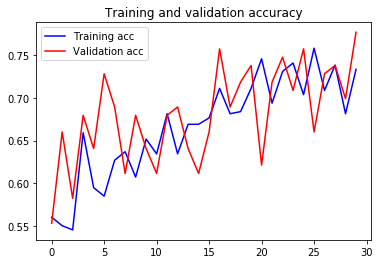

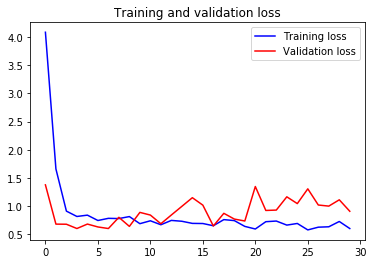

In [24]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()